In [1]:
###
#
# Study 1
#
# Aim: preliminary studies on randomized SYNEX data.
#
###

In [2]:
%matplotlib inline
# Set path to SYNEX
import os,sys
import pathlib
SYNEX_PATH=os.popen('pwd').read().split("SYNEX")[0]+"SYNEX"
sys.path.insert(1, SYNEX_PATH)
# print(sys.path)
# sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [3]:
import importlib
import numpy as np
import pandas as pd
import lisabeta.utils.plotutils as plotutils
import time
import glob
import copy
from astropy.cosmology import Planck13, z_at_value
from astropy.cosmology import WMAP9 as cosmo
from astropy.time import Time
import json
import healpy as hp
import gwemopt
from gwemopt import utils as gou
import SYNEX
from SYNEX import SYNEX_Utils as SYU
from SYNEX import SYNEX_Detectors as SYDs
from SYNEX import SYNEX_Sources as SYSs
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab
from SYNEX.SYNEX_Utils import pylab_params
pylab.rcParams.update(pylab_params)
importlib.reload(SYU)

<module 'SYNEX.SYNEX_Utils' from '/Users/baird/Documents/LabEx_PostDoc/SYNEX/SYNEX/SYNEX_Utils.py'>

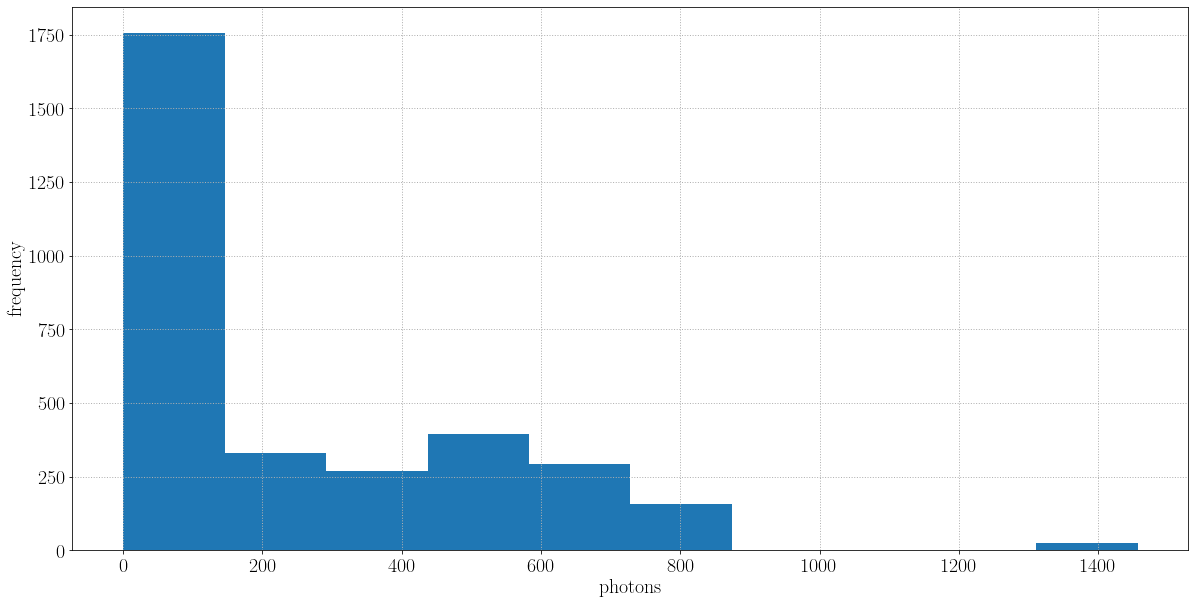

In [4]:
# Load dataframe
store = pd.HDFStore(SYNEX_PATH + '/DataFrames/Randomized_SYNEX2/data.h5')
data = store['data']  # load it

# Look at global n_photons variation
%matplotlib inline
hist = data.n_photons.hist(figsize=(20,10))
hist.set_xlabel("photons",fontsize = 20)
hist.set_ylabel("frequency",fontsize = 20)
plt.tick_params( labelsize = 20)
plt.show()

In [5]:
### Start looking at standard deviations ###

# General stats first
print(data.n_photons.describe())

# Global
STDev_all = data.n_photons.std()
print(STDev_all)

count    3226.000000
mean      227.211097
std       288.762408
min         0.000000
25%         0.000000
50%         0.000000
75%       447.000000
max      1457.000000
Name: n_photons, dtype: float64
288.76240776333077


In [6]:
# As function of Tobs
STDev_ByTobs = data.groupby(by="Tobs").n_photons.std()
print(STDev_ByTobs)

Tobs
1.0    204.381724
2.0    286.737500
3.0    300.606552
4.0    293.382941
Name: n_photons, dtype: float64


In [7]:
# As function of Tcut
STDev_ByTcut = data.groupby(by="DeltatL_cut").n_photons.std()
print(STDev_ByTcut)


DeltatL_cut
-2592000.0    271.267448
-1814400.0    276.874210
-1209600.0    285.019951
-604800.0     290.358507
-259200.0     291.422248
-86400.0      294.433070
-36000.0      296.406412
-18000.0      296.993818
Name: n_photons, dtype: float64


In [8]:
### Cross Tab to see correlations ###
# 1. Tobs - Tcut

pd.crosstab(data.Tobs, data.DeltatL_cut, values=data.n_photons, aggfunc='mean', normalize=True, margins=True, margins_name="Total")




DeltatL_cut,-2592000.0,-1814400.0,-1209600.0,-604800.0,-259200.0,-86400.0,-36000.0,-18000.0,Total
Tobs,,,,,,,,,
1.0,0.010723,0.010550,0.013313,0.014780,0.013656,0.014584,0.014731,0.015090,0.107399
2.0,0.020312,0.023290,0.026146,0.029096,0.028152,0.029077,0.028617,0.029360,0.214105
3.0,0.028286,0.032846,0.036910,0.039569,0.039283,0.040006,0.042655,0.042183,0.301644
4.0,0.036436,0.043377,0.046318,0.048029,0.051111,0.051297,0.050316,0.049900,0.376852
Total,0.095766,0.110041,0.122694,0.131472,0.132223,0.135113,0.136279,0.136412,1.000000


Randomized instrinsic variables found: ['q', 'chi1', 'chi2', 'lambda', 'beta', 'DeltatL_cut']


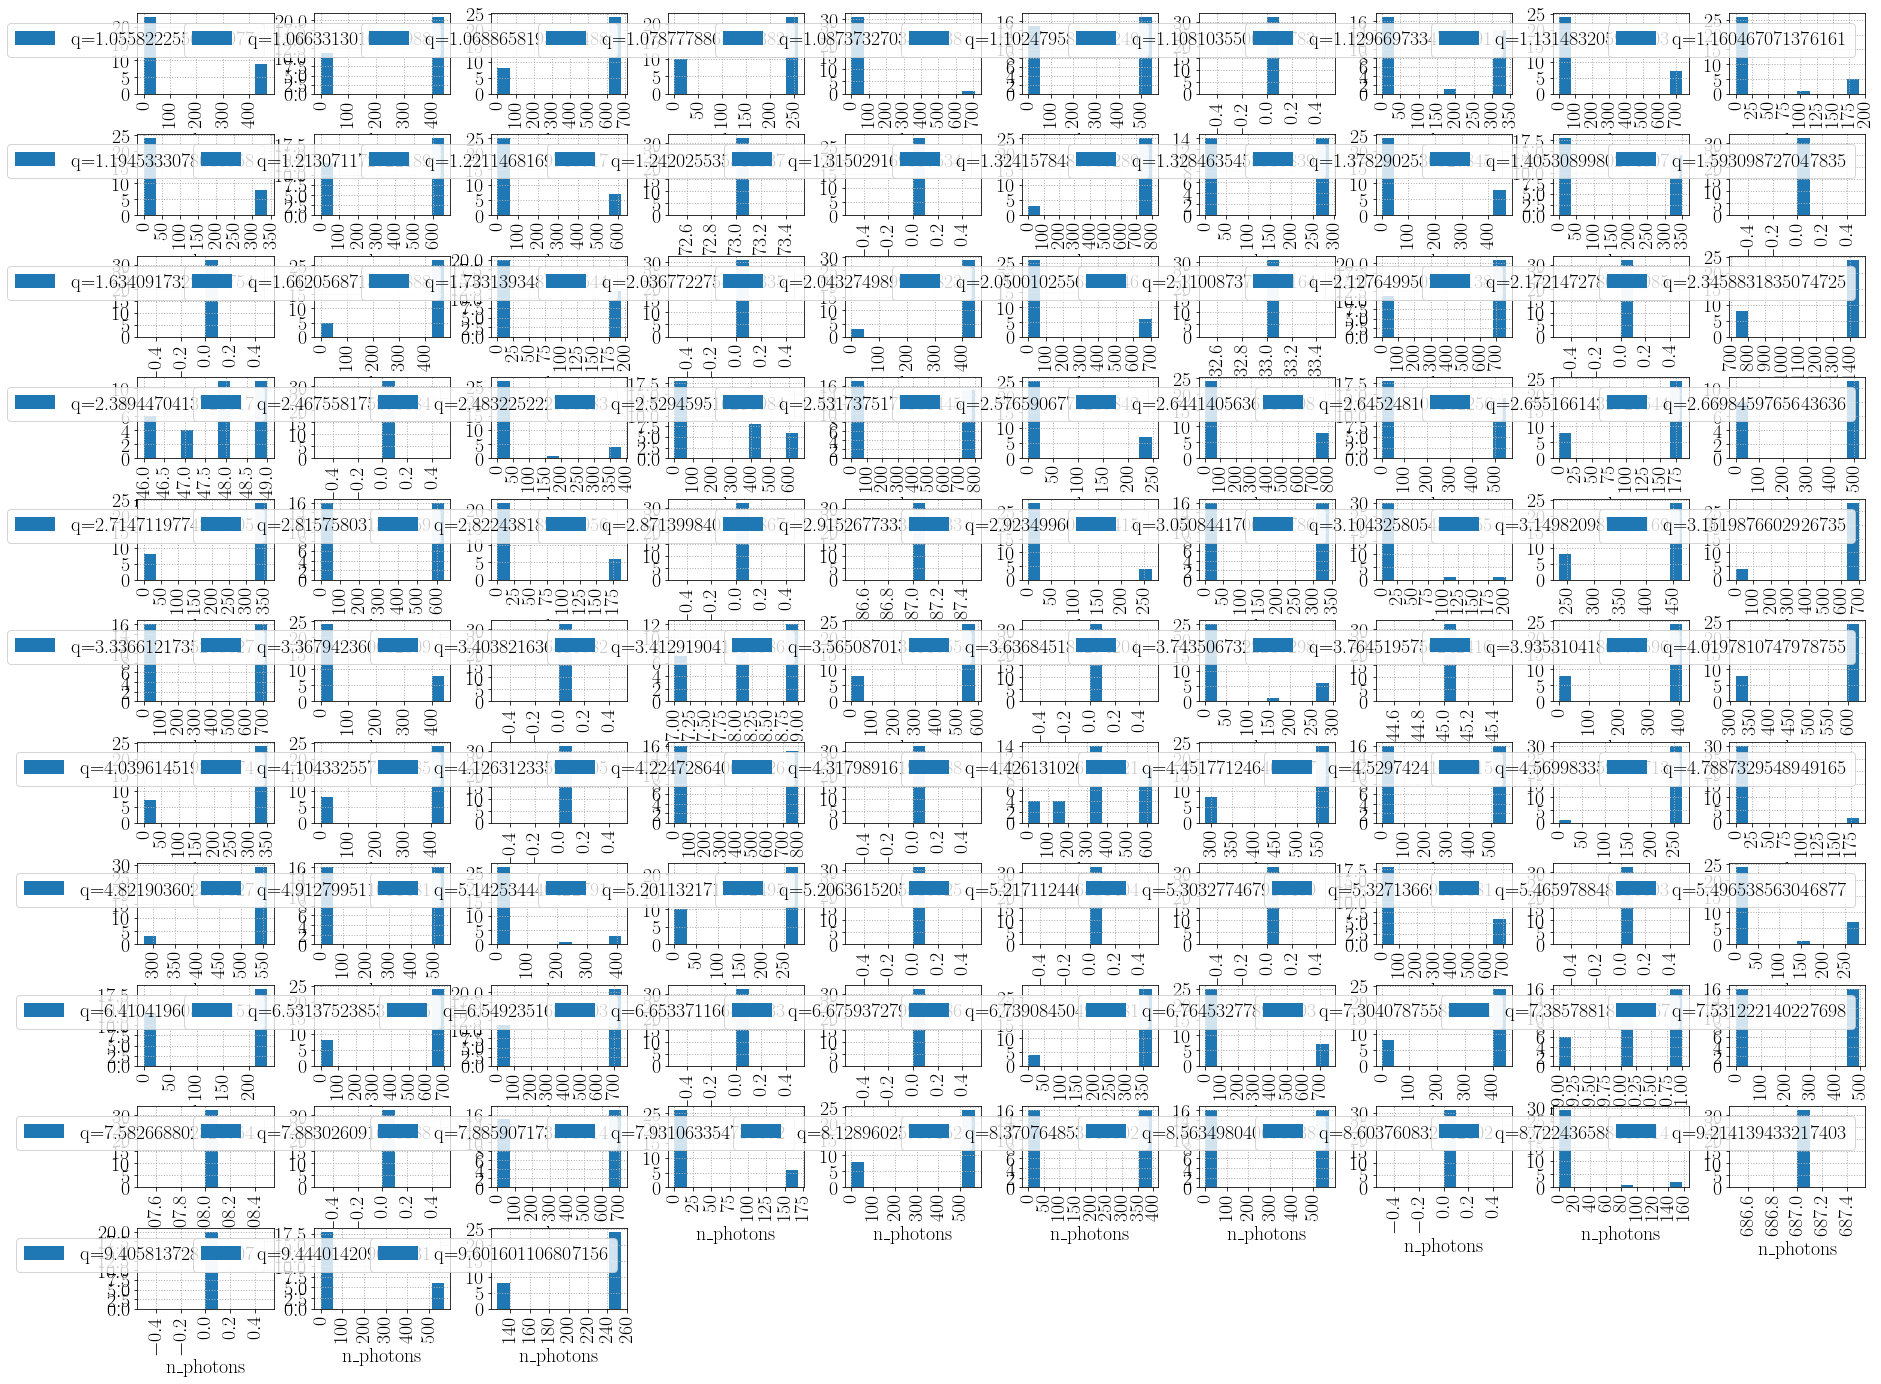

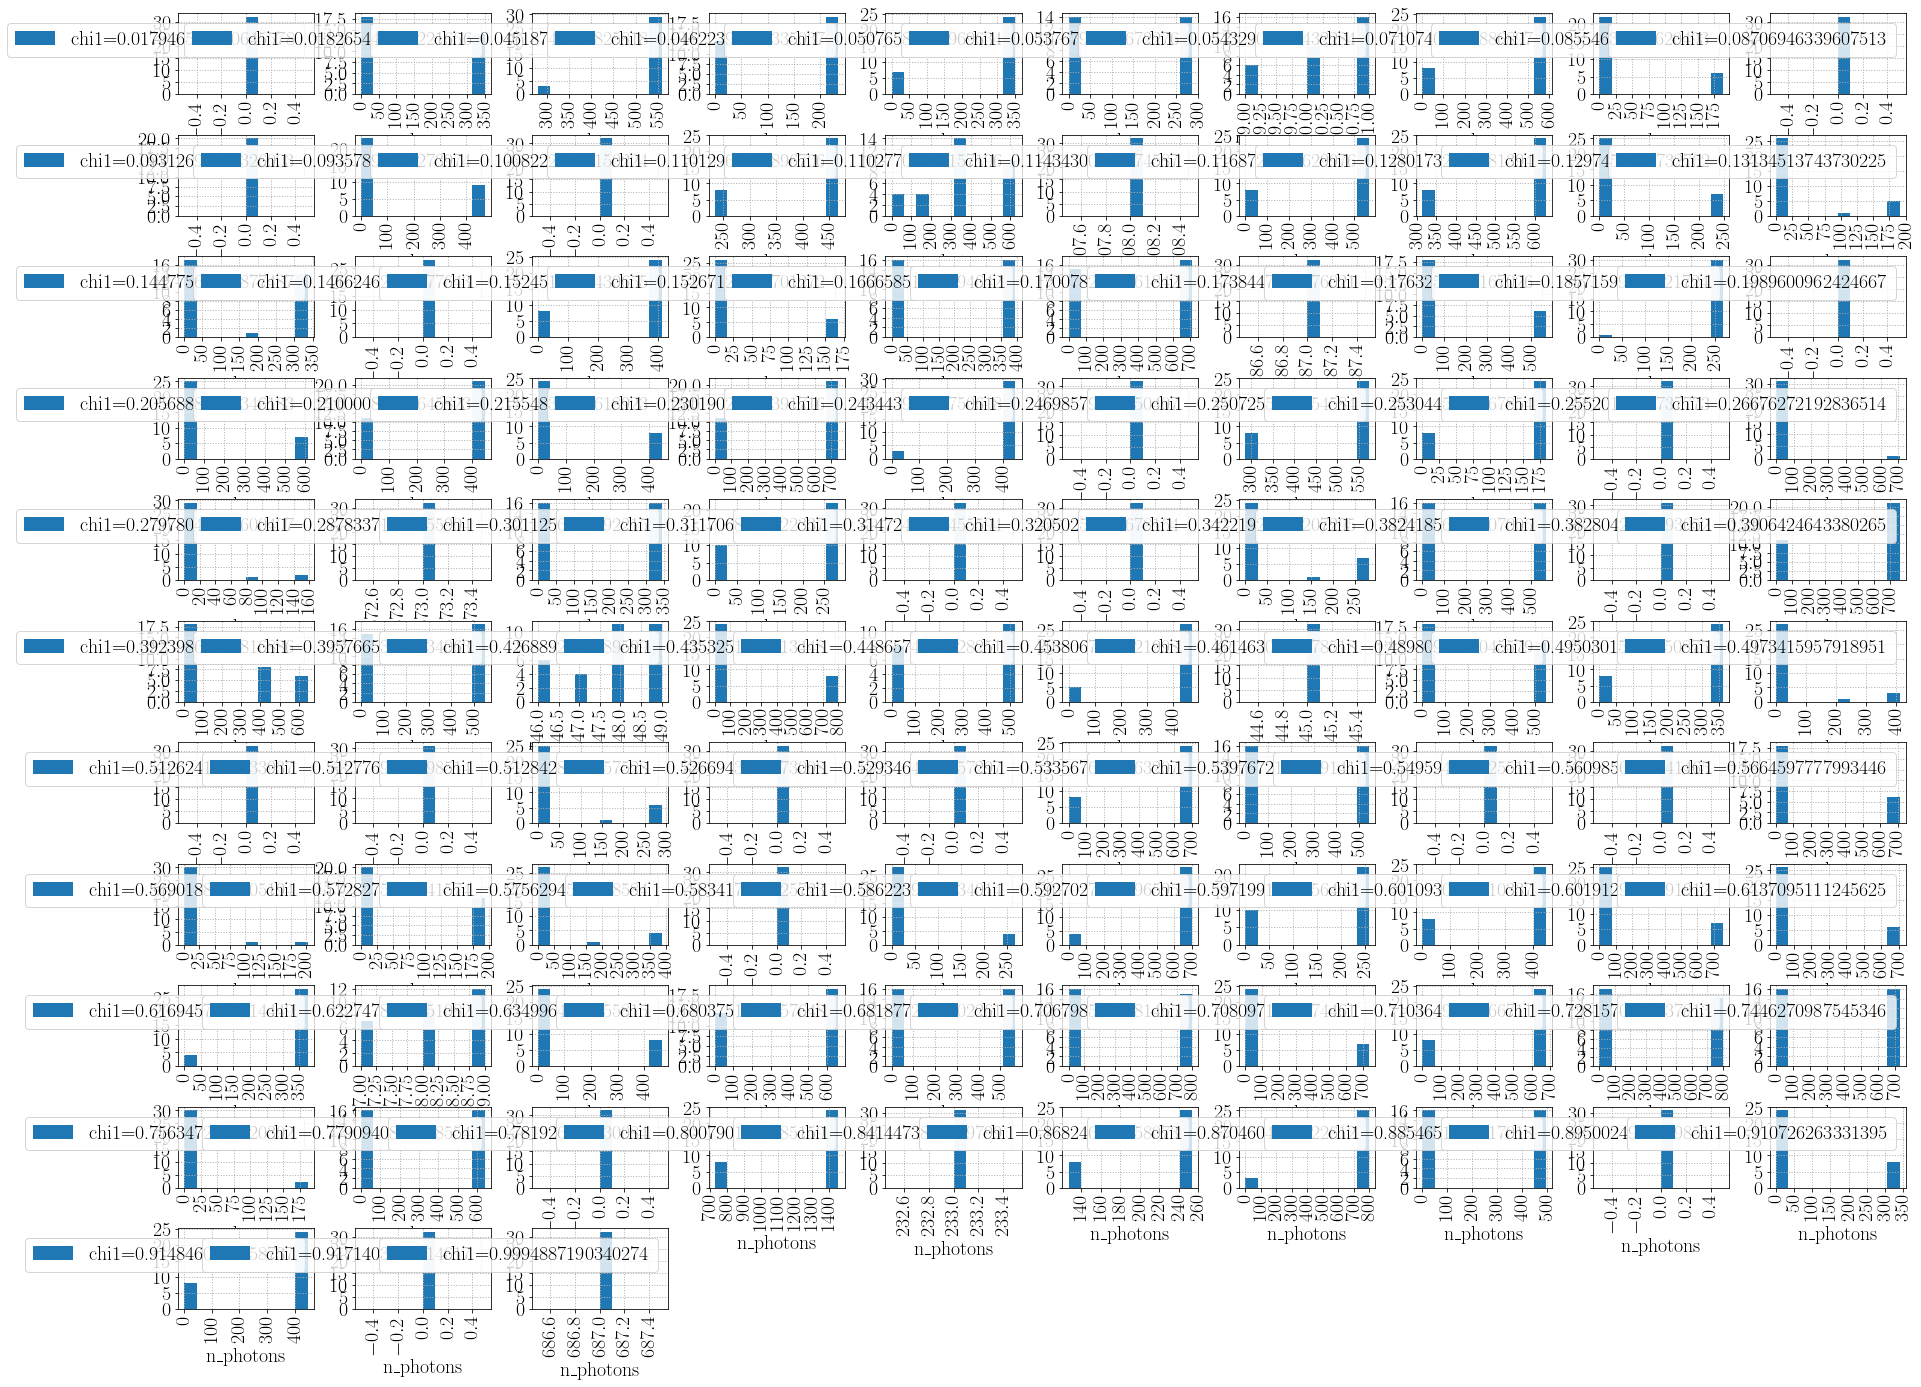

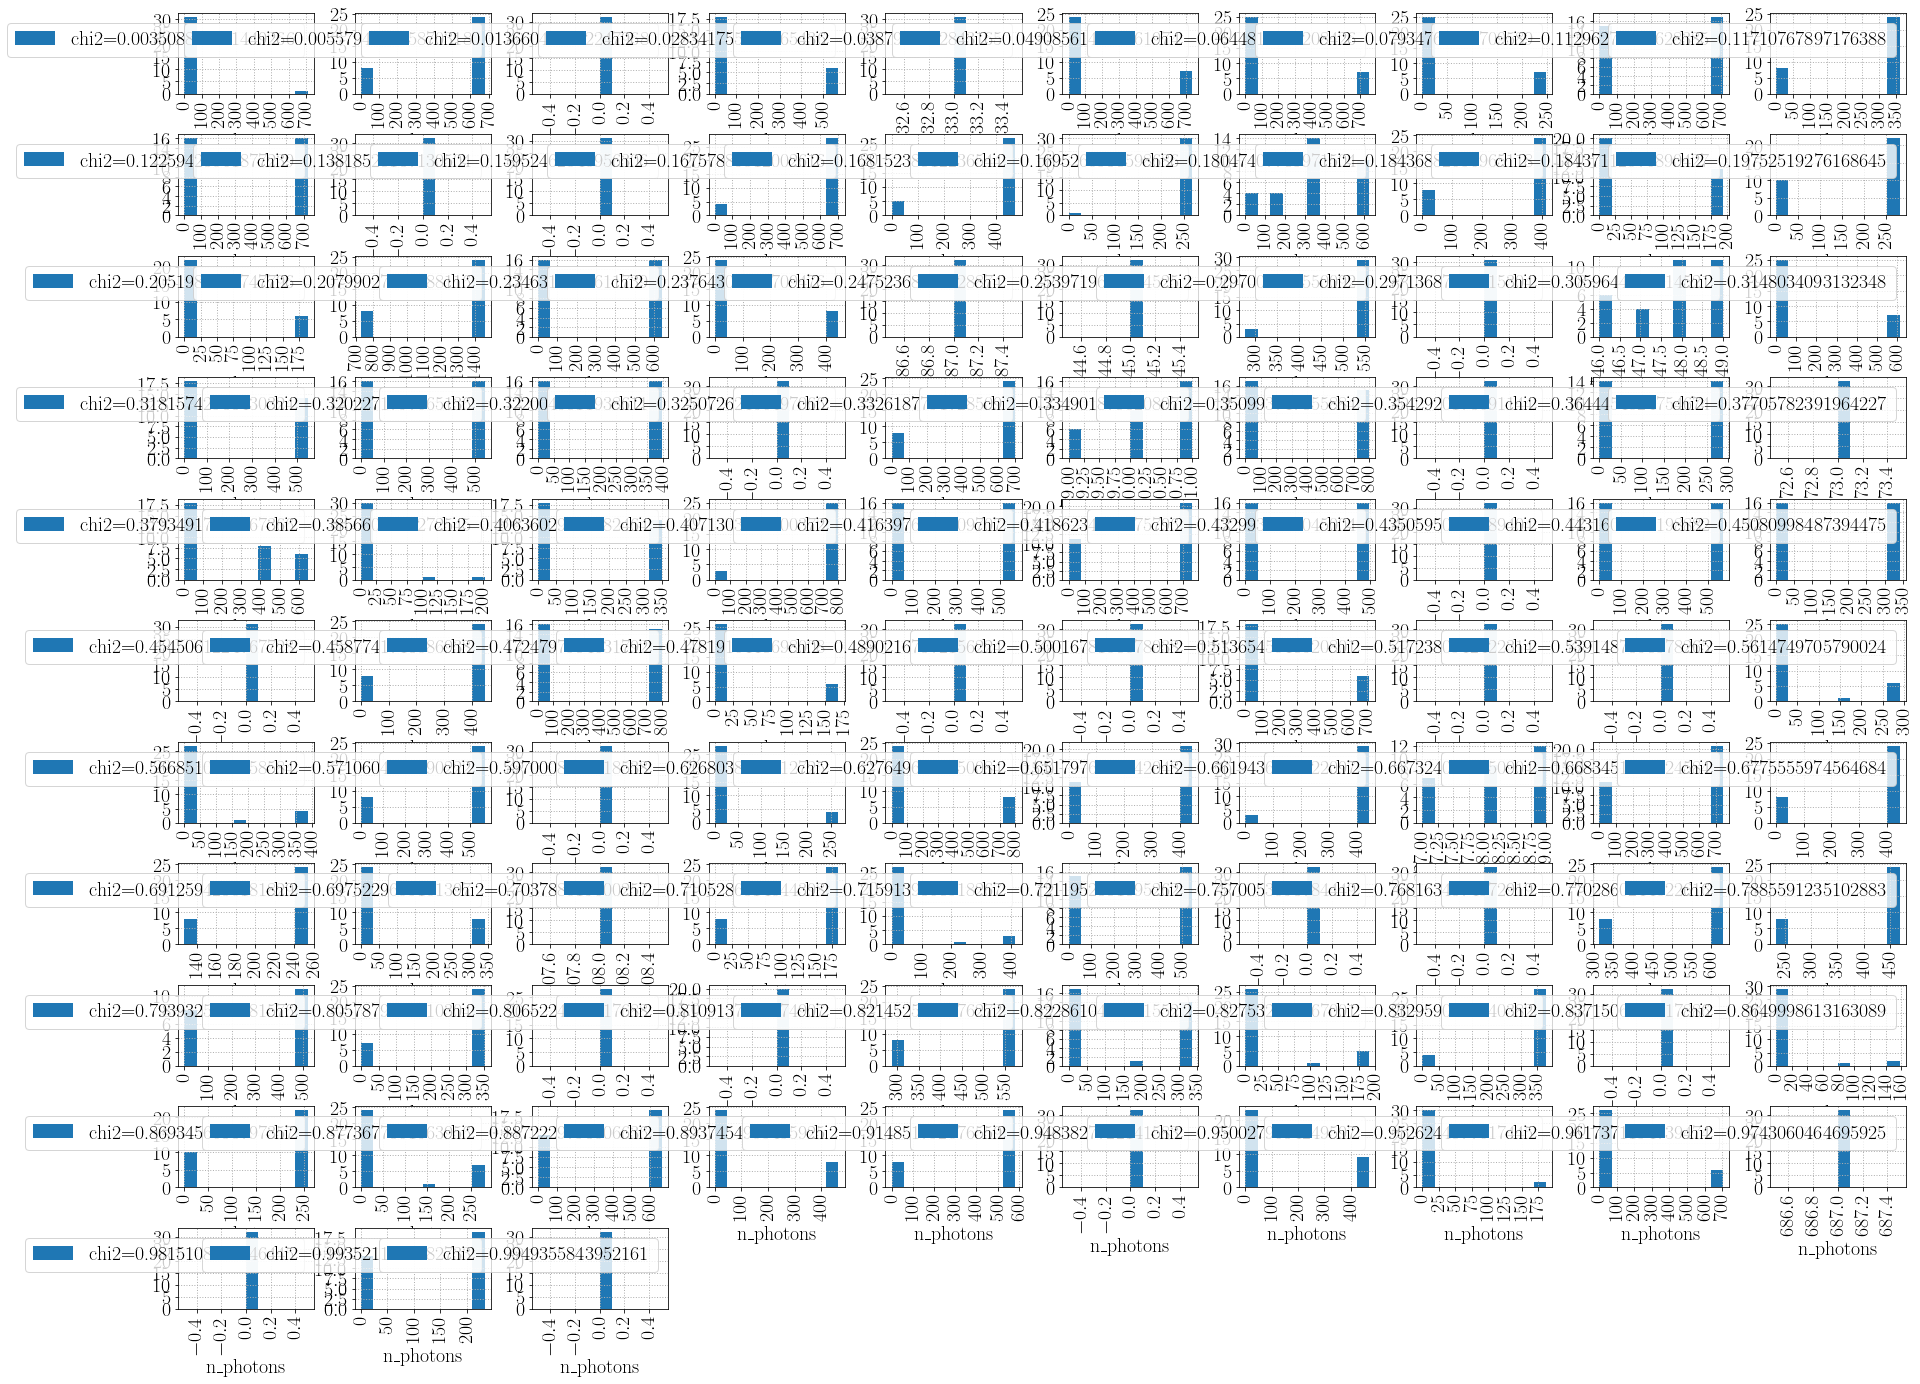

In [ ]:
### Run through instrinsic params to check for correlations there

# Get all interesting variables to test
ext_params=["n_photons","n_photons_per_tile","DaysToSourceExp","Tobs","exposuretime"]
data_unique = data.drop(["DaysToSourceExp","n_photons_per_tile"], inplace=False, axis=1).nunique() # Drop these columns because nunique doesn't like columns with list elements
int_params = [key for key in list(data_unique.index) if data_unique[key]>1 and key not in ext_params]
print("Randomized instrinsic variables found:",int_params)

# Loop through each one to get what's happening ----- NEEDS BINNING
for key in int_params:
    hist_key=data.hist(column="n_photons",by=key,bins=10,legend=False,figsize=(30, 24),xlabelsize=20,ylabelsize=20)
    for ii in range(len(hist_key)):
        for jj in range(len(hist_key[ii])):
            leg = key + "="+hist_key[ii,jj].get_title()
            hist_key[ii,jj].set_xlabel("n_photons",fontsize=20)
            hist_key[ii,jj].legend([leg],fontsize=20)
            hist_key[ii,jj].set_title(None)
    plt.show()









In [ ]:
# Plot no. non-imaged systems
Tobs=data.groupby(by="Tobs").groups.keys()
Tcut=[val/(24.*60*60) for val in data.groupby(by="DeltatL_cut").groups.keys()]

#### Try groupby(by = Tcut or Tobs).loc(n_photons==0) for each subframe created from each data[T_obs or Tcut == t_ii]
#n_photons_by_Tobs=[data.loc[data.groupby(by="Tobs").DeltatL_cut==t].n_photons for t in Tcut]
#print(n_photons_by_Tobs)

n_photons_by_Tobs = data.groupby(by="Tobs").sum().n_photons
print(n_photons_by_Tobs)
n_photons_by_Tcut = data.groupby(by="DeltatL_cut").sum().n_photons
print(type(Tobs),type(n_photons_by_Tobs))
plt.plot(Tobs,n_photons_by_Tobs)
plt.ylabel("photons",fontsize = 20)
plt.xlabel("Tobs",fontsize = 20)
plt.tick_params(labelsize = 20)
plt.show()
plt.plot(Tcut,n_photons_by_Tcut)
plt.ylabel("photons",fontsize = 20)
plt.xlabel("Tcut",fontsize = 20)
plt.tick_params(labelsize = 20)
plt.show()

# Try plotting scatters for each system to see correlations
#for key in int_params:
#    n_photons_by_Tobs = data.groupby(by="Tobs").n_photons

In [ ]:
### Cross Tab to see correlations ###
# 1. Time to first image

# df['DataFrame Column'] = df['DataFrame Column'].fillna(0)

# How many systems did we actually see in the Tobs time allowed?
LenImagedSystems = len(data.dropna(subset=['DaysToSourceExp']).index)
LenTotalSystems = len(data.index)
print(LenImagedSystems,"/",LenTotalSystems,"imaged systems")

# Calculate time to first sighting
data.loc[:,"DaysToFirstImage"] = data["DaysToSourceExp"].map(lambda x: x[0][0])

# Histograms
# plt.rcParams['figure.figsize'] = [40/2.54, 32/2.54]
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
hist_Tobs = data.hist(column="DaysToFirstImage",by="Tobs",bins=10,legend=False,figsize=(30, 24),xlabelsize=20,ylabelsize=20)
for ii in range(len(hist_Tobs)):
    for jj in range(len(hist_Tobs[ii])):
        leg = r"T$_{obs}$="+hist_Tobs[jj,ii].get_title()+r"$\,$d"
        hist_Tobs[jj,ii].set_xlabel("DaysToFirstImage",fontsize=20)
        hist_Tobs[jj,ii].legend([leg],fontsize=20)
        hist_Tobs[jj,ii].set_title(None)
plt.show()

hist_Tcut = data.hist(column="DaysToFirstImage",by="DeltatL_cut",bins=10,legend=True,figsize=(30, 24),xlabelsize=20,ylabelsize=20)
Tcuts = ["5hr","10hr","1d","3d","1wk","2wk","3wk","1mon"]
for ii in range(len(hist_Tcut)):
    for jj in range(len(hist_Tcut[ii])):
        try:
            Tcut_jjii=-float(hist_Tcut[jj,ii].get_title())/(24*60*60)
            if Tcut_jjii<1:
                Tcut_jjii=-float(hist_Tcut[jj,ii].get_title())/(60*60)
                leg = r"T$_{cut}$="+str(Tcut_jjii)+r"$\,$hr"
            else:
                leg = r"T$_{cut}$="+str(Tcut_jjii)+r"$\,$d"
            hist_Tcut[jj,ii].set_xlabel("DaysToFirstImage",fontsize=20)
            hist_Tcut[jj,ii].legend([leg],fontsize=20)
            hist_Tcut[jj,ii].set_title(None)
        except:
            print("Empty axes in figure axis array, skipping.")
plt.show()





# 2. 2D sky Hist

# Scatter plot to see how sky has been populated
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20
LamBetScatter = data.plot.scatter(x="lambda",y="beta",s=50,figsize=(10, 8))
plt.show()




# Cross tab evaluation of n_photons measured
# pd.crosstab(data.Tobs, data.DeltatL_cut, values=data.n_photons, aggfunc='mean', normalize=True, margins=True, margins_name="Total")




